In [1]:
!pip install tqdm

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from skimage import io
from skimage.transform import resize

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import cv2

import random
import os
from tqdm import tqdm

from random import randrange

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q "/content/drive/MyDrive/archive.zip"

In [ ]:
!unzip -q "/content/drive/MyDrive/archive1.zip"

In [5]:
class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self, path = "/content/mvtech_anomaly_detection/metal_nut",
                 batch_size = 4,
                 input_size=(224, 224),
                 shuffle=True, seed = None, subset = 'training'):

        self.image_data_generator = ImageDataGenerator(rescale=1. / 255, data_format='channels_last',

        )

        if seed is None:
            random.randint(0, 2**32)

        self.batch_size = batch_size
        self.input_size = input_size

        self.X_paths = [os.fsdecode(file) for file in os.scandir(f"{path}/train/good")]
        self.X_train, self.X_val = train_test_split(self.X_paths, test_size=0.2, random_state = seed, shuffle = True)

        if subset == 'training':
            self.X = self.X_train
        elif subset == 'validation':
            self.X = self.X_val

        self.n = len(self.X)


    def __getitem__(self, index):

        data_x = []

        for i in range(self.batch_size):
            image = cv2.imread(self.X[self.batch_size * index + i])

            image = self.image_data_generator.random_transform(image)

            image = image / 255

            image = tf.image.resize(image, self.input_size)
            data_x.append(image)

        data_x = np.array(data_x)

        return data_x, data_x

    def __len__(self):
        return self.n // self.batch_size

In [6]:
INPUT_SIZE = (224,224)
seed = random.randint(0, 2**32)
train_datagen = CustomDataGen(input_size = INPUT_SIZE, batch_size = 4, seed = seed)
validation_datagen = CustomDataGen(input_size = INPUT_SIZE, subset = "validation", seed = seed)

In [7]:
#Check we dont have the same images in train and validation sets
any([value in train_datagen.X for value in validation_datagen.X])

False

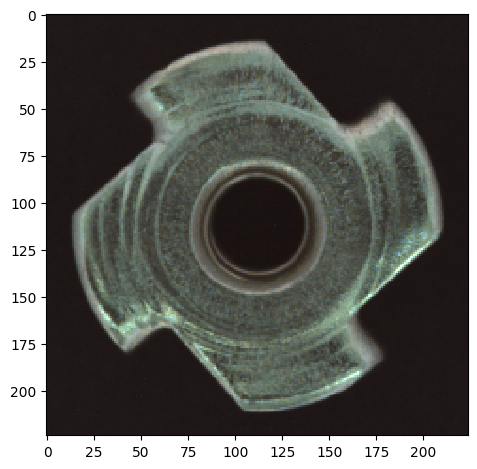

In [8]:
x, y = train_datagen[0]
io.imshow(x[0])
io.show()

In [12]:
input_model_filepath = "/content/anomaly-segmentation-VGG19model.h5"
output_model_filepath = "/content/anomaly-segmentation-model_metal_nut_100.h5"
#model class
class AnomalySegmentator(tf.keras.Model):
    def __init__(self, init_layer = 0, end_layer = None):
        super(AnomalySegmentator, self).__init__()
        #self.L2_weight = 1e-6
        self.init_layer = init_layer
        self.end_layer = end_layer

    def build_autoencoder(self, c0, cd):
        self.autoencoder = Sequential([
            layers.InputLayer((self.map_shape[0]//4, self.map_shape[1]//4, c0)),
            layers.Conv2D((c0 + cd) // 2,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(2*cd,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(cd,(1,1), padding='same'),
            layers.Conv2D(2*cd,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D((c0 + cd) // 2,(1,1), padding='same', activation = tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Conv2D(c0,(1,1), padding='same')

        ])

    def build(self, input_shape):

        self.vgg = VGG19(include_top = False, weights = 'imagenet', input_shape=input_shape[1:])
        self.features_list = [layer.output for layer in self.vgg.layers if 'conv' in layer.name][self.init_layer:self.end_layer]

        self.feature_extractor = Model(inputs = self.vgg.input,
                                       outputs = self.features_list)
        self.feature_extractor.trainable = False

        self.threshold = tf.Variable(0, trainable = False, dtype = tf.float32)

        self.map_shape = self.features_list[0].shape[1:-1]

        self.average_pooling = layers.AveragePooling2D(pool_size=(4, 4), strides=(4,4))



        self.c0 = sum([feature.shape[-1] for feature in self.features_list])
        self.cd = 40
        self.build_autoencoder(self.c0, self.cd)


    def call(self, inputs):
        features = self.feature_extractor(inputs)
        resized_features = [tf.image.resize(feature, self.map_shape) for feature in features]
        resized_features = tf.concat(resized_features, axis = -1)

        resized_features = self.average_pooling(resized_features)

        autoencoder_output = self.autoencoder(resized_features)
        return tf.reduce_sum((autoencoder_output - resized_features)**2, axis = -1)

    def reconstruction_loss(self):
        @tf.function
        def _loss(y_true, y_pred):
            loss = tf.reduce_mean(y_pred, axis = (1,2)) / (tf.cast(tf.shape(y_pred)[0], tf.float32) * self.c0)
            return loss

        return _loss

    def compute_threshold(self, data_loader, fpr = 0.05):
      error = []
      for i in tqdm(range(len(data_loader))):
        x, y = data_loader[i]
        error.append(self(x))

      threshold = np.percentile(error, 100 - fpr)
      self.threshold = tf.Variable(threshold, trainable = False, dtype = tf.float32)

    def compute_pca(self, data_loader):
        extraction_per_sample = 20

        extractions = []
        for i in tqdm(range(len(data_loader))):
            x, _ = data_loader[i]

            features = self.feature_extractor(x)
            resized_features = [tf.image.resize(feature, self.map_shape) for feature in features]
            resized_features = tf.concat(resized_features, axis = -1)

            resized_features = self.average_pooling(resized_features)

            for feature in resized_features:

                for _ in range(extraction_per_sample):

                    row, col = randrange(feature.shape[0]), randrange(feature.shape[1])
                    extraction = feature[row, col]
                    extractions.append(extraction)

        extractions = np.array(extractions)
        print(f"Extractions Shape: {extractions.shape}")
        pca = PCA(0.9, svd_solver = "full")
        pca.fit(extractions)
        self.cd = pca.n_components_
        self.build_autoencoder(self.c0, self.cd)
        print(f"Components with explainable variance 0.9 -> {self.cd}")

as_model = AnomalySegmentator()
as_model.compile(Adam(1e-4), loss = as_model.reconstruction_loss())

In [13]:
as_model.build((None, *INPUT_SIZE,3))
as_model.compute_pca(train_datagen)

100%|██████████| 44/44 [00:17<00:00,  2.56it/s]


Extractions Shape: (3520, 5504)
Components with explainable variance 0.9 -> 68


In [14]:
from tensorflow.keras import backend as K
K.clear_session()


Epoch 1/100
44/44 [==============================] - 50s 1s/step - loss: 0.6315 - val_loss: 0.6295 - lr: 1.0000e-04
Epoch 2/100
44/44 [==============================] - 47s 1s/step - loss: 0.6037 - val_loss: 0.6017 - lr: 1.0000e-04
Epoch 3/100
44/44 [==============================] - 48s 1s/step - loss: 0.5766 - val_loss: 0.5801 - lr: 1.0000e-04
Epoch 4/100
44/44 [==============================] - 52s 1s/step - loss: 0.5545 - val_loss: 0.5581 - lr: 1.0000e-04
Epoch 5/100
44/44 [==============================] - 49s 1s/step - loss: 0.5355 - val_loss: 0.5412 - lr: 1.0000e-04
Epoch 6/100
44/44 [==============================] - 47s 1s/step - loss: 0.5186 - val_loss: 0.5215 - lr: 1.0000e-04
Epoch 7/100
44/44 [==============================] - 49s 1s/step - loss: 0.5007 - val_loss: 0.5069 - lr: 1.0000e-04
Epoch 8/100
44/44 [==============================] - 47s 1s/step - loss: 0.4874 - val_loss: 0.4933 - lr: 1.0000e-04
Epoch 9/100
44/44 [==============================] - 49s 1s/step - loss:

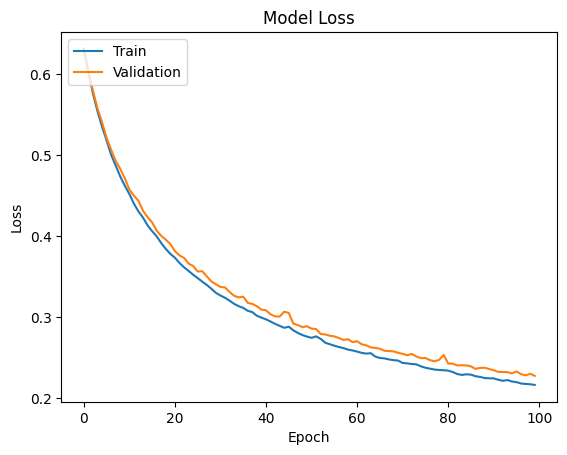

100%|██████████| 44/44 [00:26<00:00,  1.66it/s]


In [32]:

if True:
    # Training the model
    plateau = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.5, patience=5, verbose = 1
    )
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                          patience=15)  # Early stopping (stops training when validation doesn't improve for epochs)
    save_best = tf.keras.callbacks.ModelCheckpoint(output_model_filepath, monitor='val_loss', save_best_only=True,
                                                mode='min', save_weights_only = True)  # Saves the best version of the model to disk

    history = as_model.fit(train_datagen,
        epochs=100,
        validation_data=validation_datagen,
        shuffle=True,
        callbacks=[es, save_best, plateau])

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    as_model.load_weights(output_model_filepath)
    as_model.compute_threshold(train_datagen)
    as_model.save_weights(output_model_filepath)


else:

    as_model.build((None, *INPUT_SIZE,3))
    as_model.load_weights(input_model_filepath)
    as_model.compute_threshold(train_datagen)
    as_model.summary()
    as_model.autoencoder.summary()


In [33]:
weights_filepath = "/content/anomaly-segmentation-model_metal_nut_100_weights.h5"
as_model.save_weights(weights_filepath)

# Ağırlıkları yükleyin
as_model.load_weights(weights_filepath)

In [34]:
classes = ['bent', 'color', 'flip', 'good','scratch'] #0 index is GOOD
test_datagen = ImageDataGenerator(rescale=1. / 255, data_format='channels_last')
test_generator = test_datagen.flow_from_directory("/content/mvtech_anomaly_detection/metal_nut/test",
                                                  target_size = INPUT_SIZE,
                                                  batch_size = 1,
                                                  class_mode = 'sparse')

Found 115 images belonging to 5 classes.


100%|██████████| 115/115 [00:17<00:00,  6.58it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      Metric     Value
0  Precision  0.071588
1     Recall  0.217391
2   F1-Score  0.101565
3    ROC AUC  0.605540


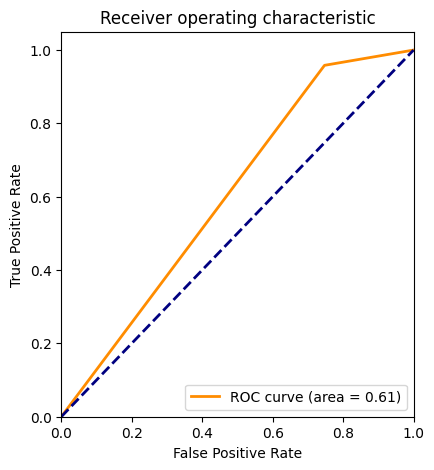

In [37]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

predictions = []
y_true = []

for i in tqdm(range(len(test_generator))):
    x_batch, y_batch = next(test_generator)
    hotmaps = as_model(x_batch)

    for x, y, hotmap in zip(x_batch, y_batch, hotmaps):
        prediction = np.any(hotmap.numpy() > as_model.threshold.numpy())
        predictions.append(int(prediction))
        y_true.append(int(y))

# ROC
fpr, tpr, thresholds = roc_curve(y_true, predictions, pos_label=1)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# Precision, Recall ve F1-Score'u hesapla
precision = precision_score(y_true, predictions, average='weighted')
recall = recall_score(y_true, predictions, average='weighted')
f1 = f1_score(y_true, predictions, average='weighted')

results = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'ROC AUC'],
    'Value': [precision, recall, f1, roc_auc]
})

print(results)


In [36]:
for i in range(10):
    x_batch, y_batch = next(test_generator)
    hotmaps = as_model(x_batch)
    for x, y, hotmap in zip(x_batch, y_batch, hotmaps):

        prediction = np.any(hotmap > as_model.threshold)

        hotmap = resize(hotmap, x.shape[:-1], anti_aliasing = True)
        mask = np.where(hotmap > as_model.threshold, 1, 0)


        f, axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(x)
        axarr[1].imshow(mask)
        axarr[1].imshow(x, alpha = 0.75)
        plt.show()

        print(f"Threshold: {as_model.threshold.numpy()} MaxValue: {hotmap.max()}")
        print(f"GT: {classes[int(y)]}, anomaly detected: {prediction}")


Output hidden; open in https://colab.research.google.com to view.